In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

## First load a few images to identify ROIs and check threshold

In [2]:
pgroup='p17502'
runnumber = 20
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
print (jsonfile)
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
print ('Scan contains {} step(s), scanvar goes {} to {}'.format(len(scan), scan.readbacks[0], scan.readbacks[-1]))

run: 0020
/sf/alvra/data/p17502/raw/run0020-test_scan_on_off/meta/scan.json
Scan contains 6 step(s), scanvar goes 888433.4241660275 to 890433.4744808356


In [3]:
threshold_low = 0
threshold_high = 100

Timezero_mm = 100.02694

channels_list = []

#####################################################

import sfdata.sfdatafile
sfdata.sfdatafile.ju = None
scan = SFScanInfo(jsonfile)

try:
    Timezero_mm = get_timezero_NBS(jsonfile)
    flag = True
except:        
    Timezero_mm = Timezero_mm
    flag = False
    
spectra_on, spectra_off, ROIs, Delay_fs, Delay_mm = XES_delayscan_ROIs(scan, channels_list, threshold_low, threshold_high)

print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

if scan.parameters['units'] == ['nS']:
    Delay_fs = scan.values
#    Delay_fs = Delay_fs - 0.17
else:
    Delay_fs = scan.values
    Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)

Processing: run0020-test_scan_on_off
Step 6 of 6: Processing acq0006

--------------------------------------------------------------------------------

JF02T09V03:ROI_Ka1      51 / 51 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_Ka2      51 / 51 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_Kb1      51 / 51 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_Kb2      51 / 51 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL4:EvtSet 51 / 51 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 51 / 51 -> 0% loss
complete channels: 5 / 5 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 25 pump and 25 unpump shots
------------------------------
Timezero found in file = 133.322720000045 mm


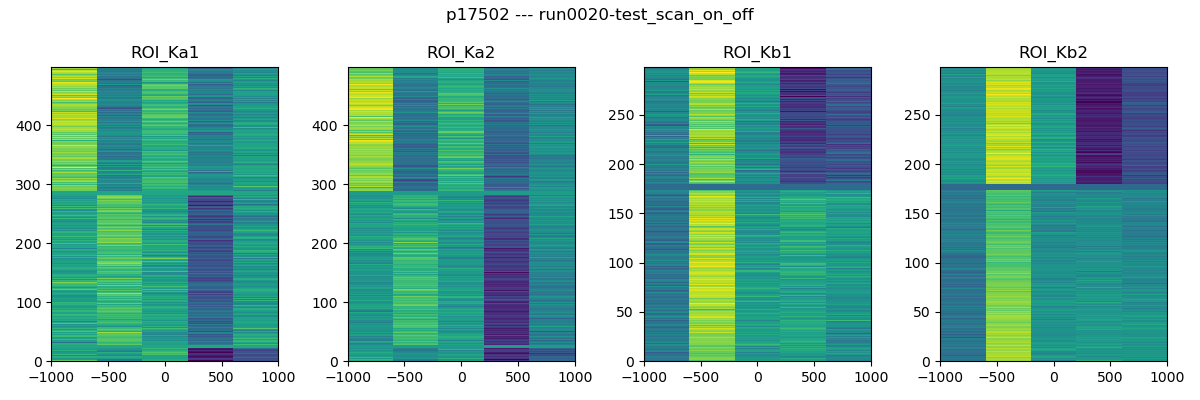

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=len(ROIs), figsize=(12,4))
plt.suptitle(titlestring)
for i, (key, ax) in enumerate(zip(ROIs, axs.flatten())):
    matrix_on = []
    matrix_off = []
    for index_step in range(len(spectra_on)):
        matrix_on.append(spectra_on[index_step][key.split(':')[-1]])
        matrix_off.append(spectra_off[index_step][key.split(':')[-1]])
    plt.sca(ax)
    plt.title(key)
    plt.pcolormesh(Delay_fs, np.arange(np.shape(matrix_on)[1]), np.transpose(np.asarray(matrix_on) - np.asarray(matrix_off)))
plt.tight_layout()